In [70]:
import pandas as pd
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data
from plot_utils import visualize_category_sounds



Analyzing Animals category...


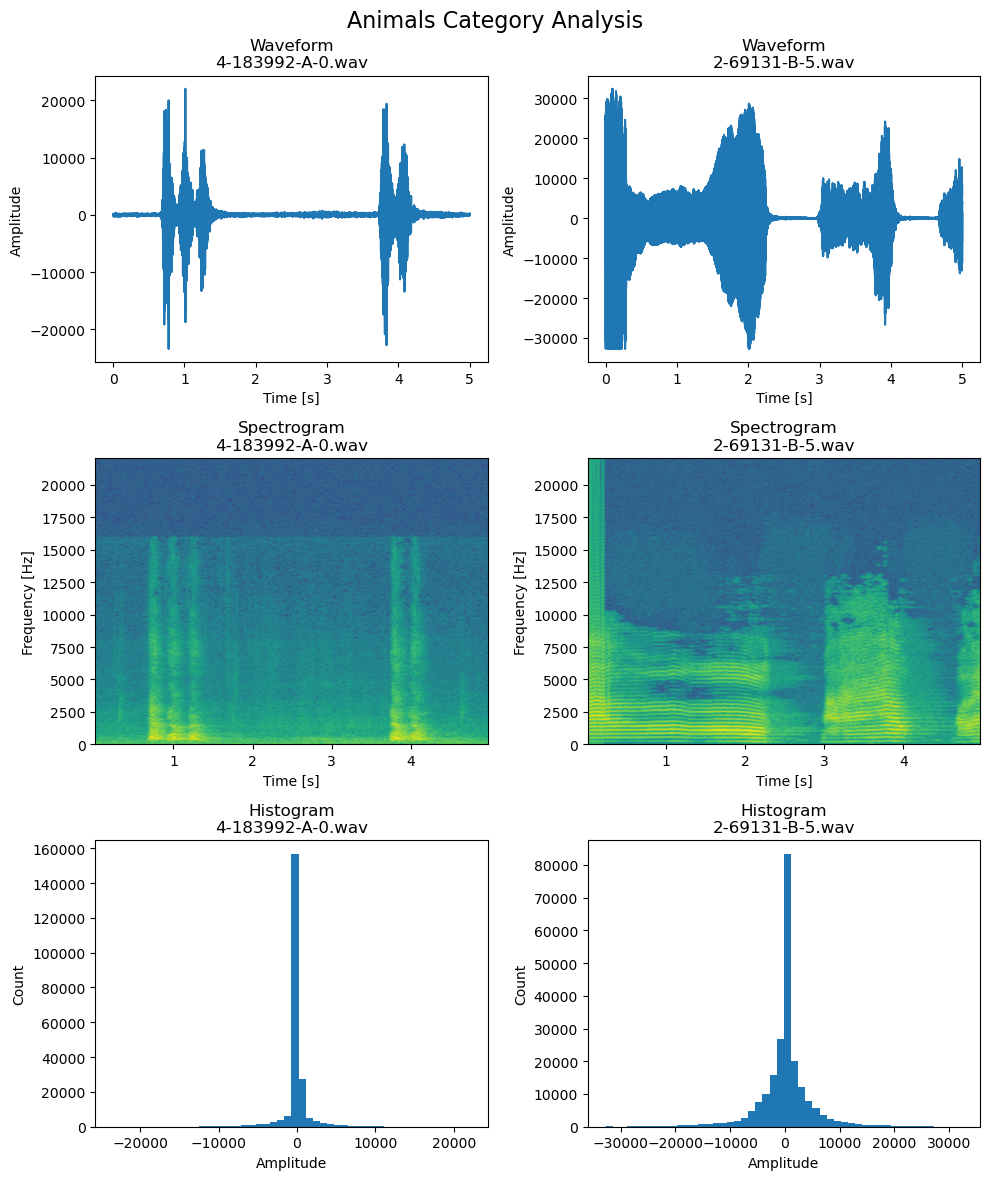

Analyzing Natural soundscapes & water sounds category...


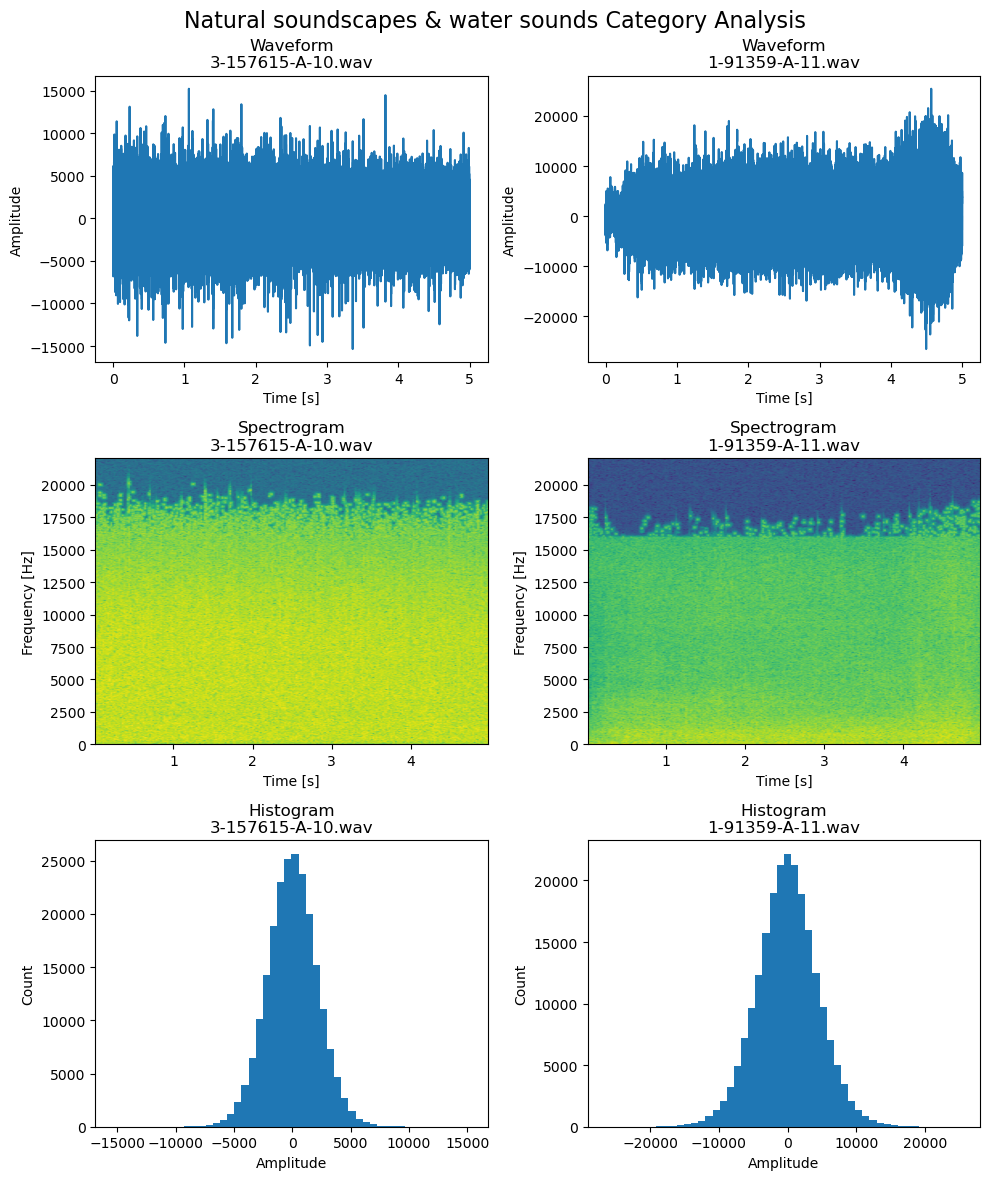

Analyzing Human sounds category...


/Users/amir/Documents/projects/SSE/AML/Final Assignment/plot_utils.py:29: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(t, f, 20 * np.log10(Sxx), shading='gouraud')


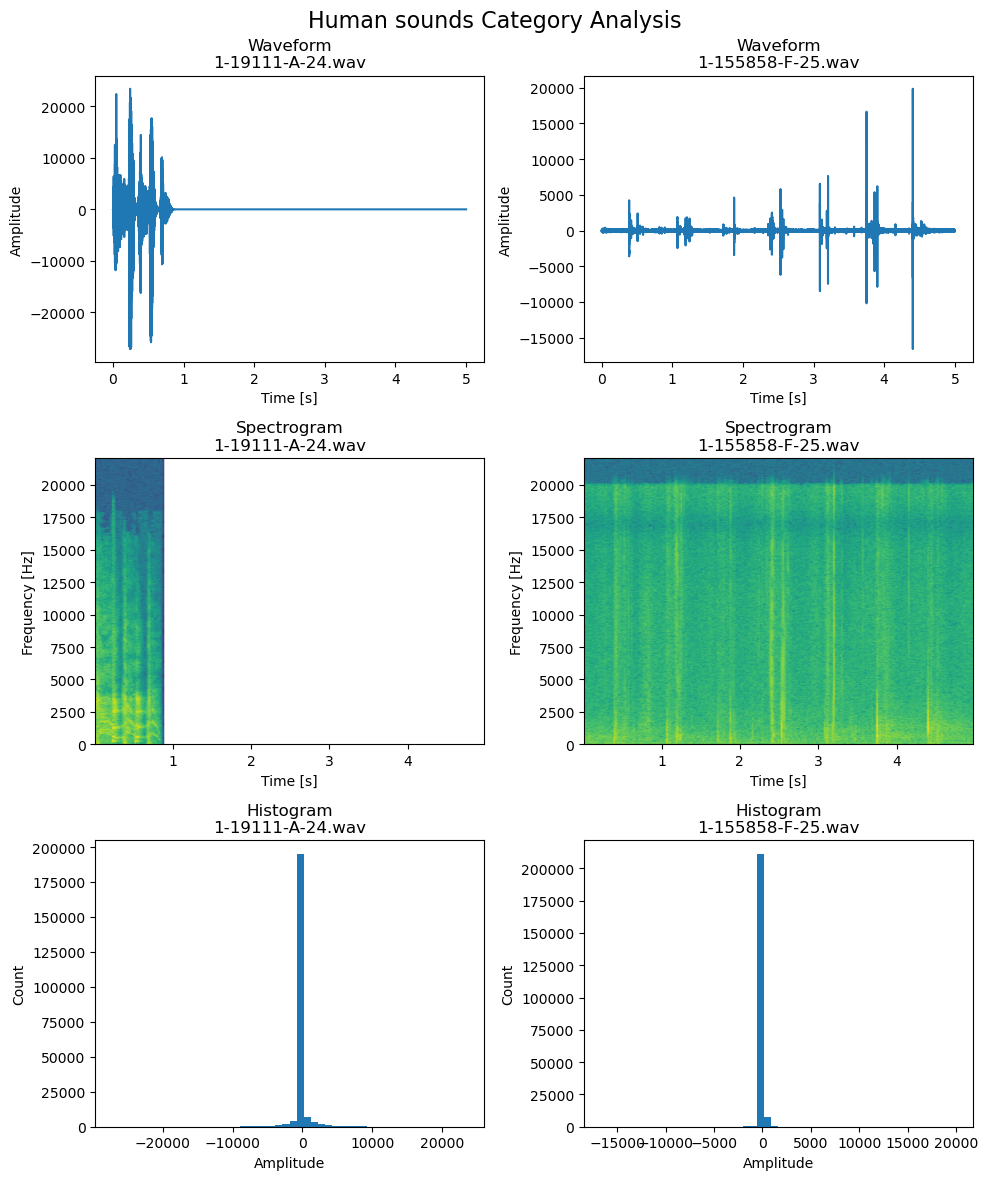

Analyzing Interior/domestic sounds category...


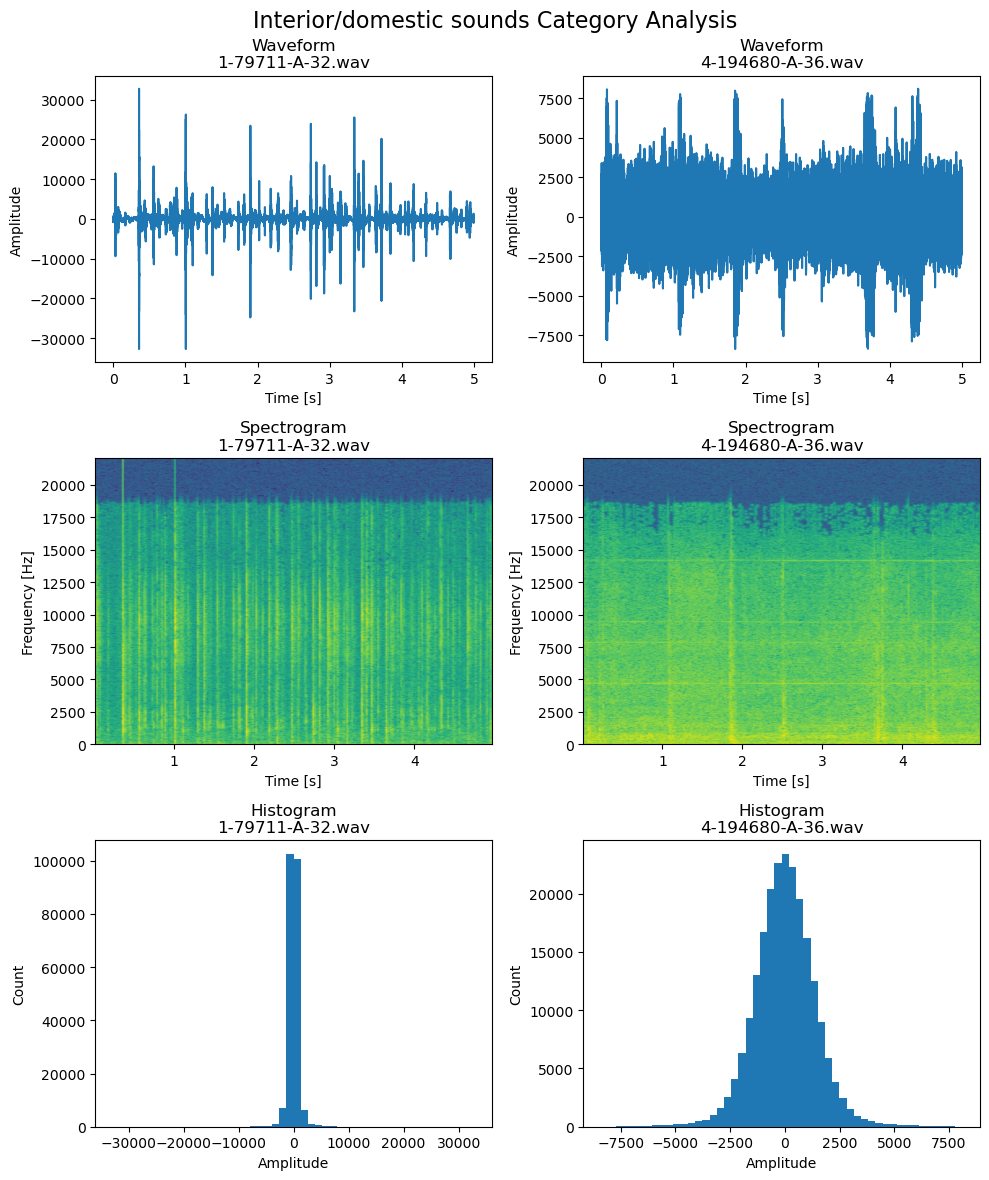

Analyzing Exterior/urban noises category...


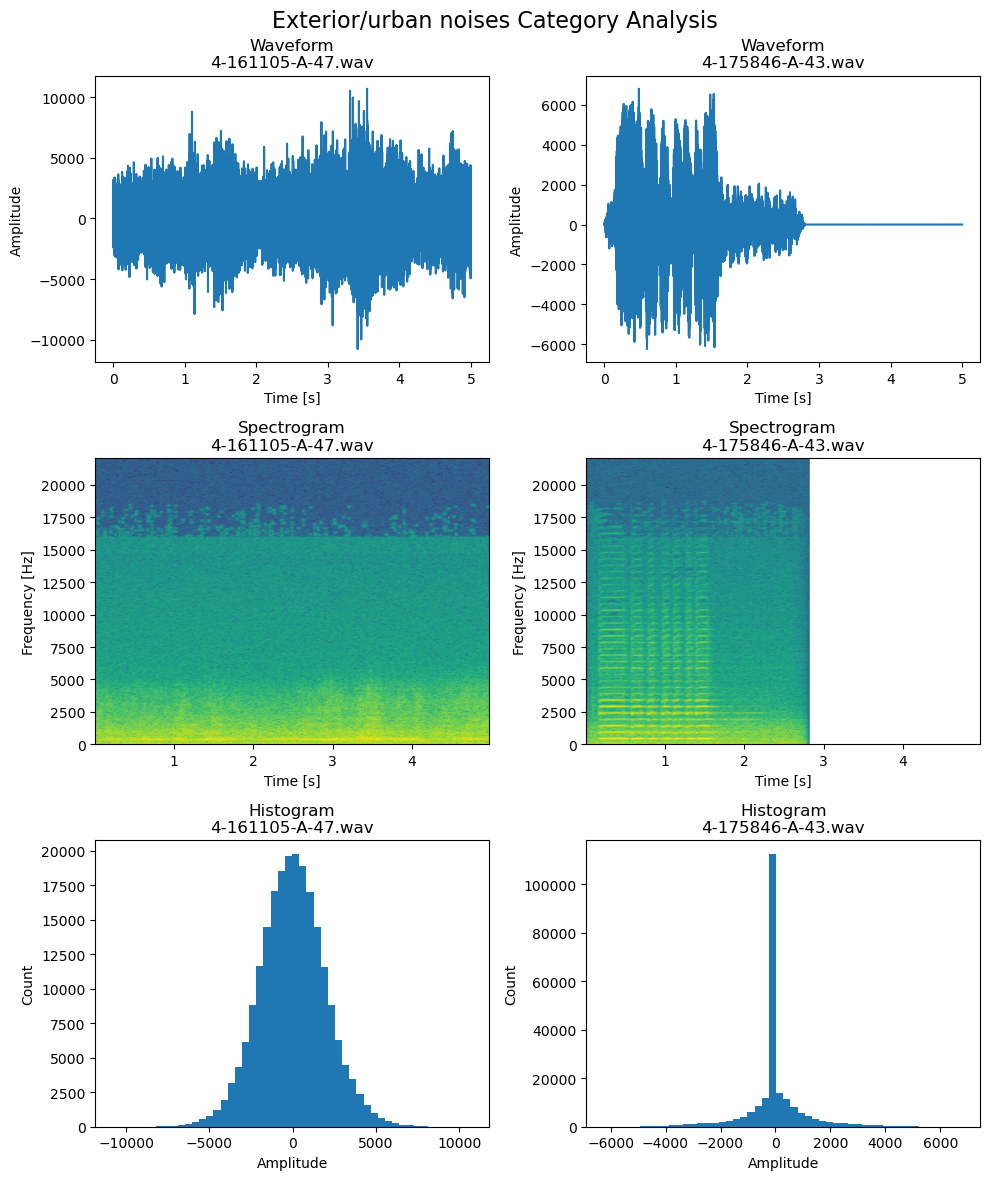

In [71]:
# 1) Specify paths
csv_file_path = "ESC-50-master/meta/esc50.csv"
audio_files_path = "ESC-50-master/audio/"

# 2) Load metadata
df = load_metadata(csv_file_path)

# 3) Define categories
categories = {
    'Animals': ['dog', 'cat'],
    'Natural soundscapes & water sounds': ['rain', 'sea_waves'],
    'Human sounds': ['coughing', 'footsteps'],
    'Interior/domestic sounds': ['keyboard_typing', 'vacuum_cleaner'],
    'Exterior/urban noises': ['airplane', 'car_horn']
}

# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# 5) Load wave data
wave_list_data = load_wave_data(sampled_sounds, audio_files_path)

# 6) Visualize
visualize_category_sounds(wave_list_data)

In [72]:
def extract_mfcc(sound_data, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512):
    """
    Extract MFCC features from audio data.
    Returns an array of shape (n_mfcc, T) where T is the number of frames.
    """
    # Convert to float (if needed) to ensure librosa doesn’t complain
    # some files from ESC-50 might be int16
    sound_data_float = sound_data.astype(np.float32)  
    
    # Compute MFCC (shape: (n_mfcc, number_of_frames))
    mfcc = librosa.feature.mfcc(
        y=sound_data_float,
        sr=sample_rate,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    
    # Optionally, you can compute the first and second derivatives:
    # delta_mfcc = librosa.feature.delta(mfcc)
    # delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    # combined = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    
    return mfcc

mfcc_features = extract_mfcc(sound_data, sample_rate, n_mfcc=13)
mfcc_mean = np.mean(mfcc_features, axis=1)   # shape = (13,)
mfcc_std = np.std(mfcc_features, axis=1)     # shape = (13,)
feature_vector = np.concatenate([mfcc_mean, mfcc_std])  # shape = (26,)


In [73]:
def extract_binned_spectrogram_hist(sound_data, sample_rate, 
                                    n_fft=2048, 
                                    hop_length=512, 
                                    n_bands=8, 
                                    n_magnitude_bins=10):
    """
    - Calculates the STFT,
    - Splits frequency into n_bands,
    - For each band, computes a histogram of the magnitudes with n_magnitude_bins.
    Returns a feature vector of length (n_bands * n_magnitude_bins).
    """
    sound_data_float = sound_data.astype(np.float32)
    
    # Compute STFT -> shape: (1 + n_fft/2, num_frames)
    stft = librosa.stft(sound_data_float, n_fft=n_fft, hop_length=hop_length)
    # Magnitude
    spectrogram = np.abs(stft)
    
    # Number of frequency bins
    freq_bins = spectrogram.shape[0]
    
    # Divide freq_bins into n_bands
    band_size = freq_bins // n_bands
    
    # We will collect histograms here
    hist_features = []
    
    for b in range(n_bands):
        # Frequency range for this band
        start_idx = b * band_size
        # Last band might contain more bins if freq_bins not perfectly divisible
        end_idx = (b+1) * band_size if b < n_bands - 1 else freq_bins
        
        # Extract the band
        band_data = spectrogram[start_idx:end_idx, :]
        
        # Flatten the magnitude data in this band
        band_magnitudes = band_data.flatten()
        
        # Compute histogram of magnitudes
        # range = (0, band_magnitudes.max()) to set upper limit for bins
        # or pick a fixed max or log-scale
        hist, bin_edges = np.histogram(
            band_magnitudes, 
            bins=n_magnitude_bins, 
            range=(0, band_magnitudes.max() + 1e-9)
        )
        
        # You might want to normalize the histogram
        hist = hist / np.sum(hist)
        
        hist_features.extend(hist.tolist())
    
    return np.array(hist_features)


In [74]:
import numpy as np

# Prepare dictionaries to store the features
mfcc_features_dict = {}
binned_hist_features_dict = {}

for category, filename, sample_rate, sound_data in wave_list_data:
    # Unique key for this audio, e.g. "category_filename"
    audio_key = f"{category}_{filename}"
    
    # Extract MFCC
    mfcc = extract_mfcc(sound_data, sample_rate, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    mfcc_feature_vector = np.concatenate([mfcc_mean, mfcc_std])  # shape: (26,)
    
    # Extract binned spectrogram histogram
    binned_hist = extract_binned_spectrogram_hist(sound_data, sample_rate, 
                                                  n_fft=2048, 
                                                  hop_length=512, 
                                                  n_bands=8, 
                                                  n_magnitude_bins=10)
    
    # Store
    mfcc_features_dict[audio_key] = mfcc_feature_vector
    binned_hist_features_dict[audio_key] = binned_hist

# Convert these dictionaries to a format easy to save
# For example, let's turn them into 2D arrays if you like
all_audio_keys = list(mfcc_features_dict.keys())
mfcc_matrix = np.array([mfcc_features_dict[key] for key in all_audio_keys])
binned_hist_matrix = np.array([binned_hist_features_dict[key] for key in all_audio_keys])



np.savez("features/extracted_features.npz", 
         keys=all_audio_keys, 
         mfcc=mfcc_matrix, 
         binned_hist=binned_hist_matrix)